## Import relevant libraries and functions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator, 
    perform_experiments,
    Samplers, Constant,
    RealParameter, Scenario
)
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.analysis import (feature_scoring, pairs_plotting, prim)

from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

## Prepare model and parameters

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [3]:
# defining specific policies

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

zeropolicy = Policy("zero policy",**dict(get_do_nothing_dict()))

## Open experiments

In [4]:
with open('experiments_SOBOL_10000xzero', 'rb') as file:
    experiments = pickle.load(file)
    
with open('outcomes_SOBOL_10000xzero', 'rb') as file:
    outcomes = pickle.load(file)

## Scenario Discovery

In [5]:
def sum_three_arrays_in_dict(dictionary, key1, key2, key3, result_key):
    if key1 in dictionary and key2 in dictionary and key3 in dictionary:
        array1 = dictionary[key1]
        array2 = dictionary[key2]
        array3 = dictionary[key3]
        
        if isinstance(array1, np.ndarray) and isinstance(array2, np.ndarray) and isinstance(array3, np.ndarray):
            if array1.shape == array2.shape == array3.shape:
                dictionary[result_key] = array1 + array2 + array3
            else:
                raise ValueError(f"Arrays under keys '{key1}', '{key2}', and '{key3}' are not of the same shape")
        else:
            raise TypeError(f"Values under keys '{key1}', '{key2}', and '{key3}' are not NumPy arrays")
    else:
        raise KeyError(f"Keys '{key1}', '{key2}', and/or '{key3}' not found in the dictionary")

    return dictionary

## Convert arrays to dataframes, sort them for the best scenario (10%)

In [7]:
df_damages = pd.DataFrame(outcomes['Expected Annual Damage'])
df_deaths = pd.DataFrame(outcomes['Expected Number of Deaths'])
new_cost_dict = sum_three_arrays_in_dict(outcomes, 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Total Costs')
df_costs = pd.DataFrame(new_cost_dict['Total Costs'])

In [22]:
percent_cutoff = int(0.1*len(outcomes['Expected Annual Damage']))
best_value_damages = df_damages.sort_values(by=0, ascending=True).iloc[percent_cutoff][0]
worst_value_damages = df_damages.sort_values(by=0, ascending=False).iloc[percent_cutoff][0]

best_value_deaths = df_deaths.sort_values(by=0, ascending=True).iloc[percent_cutoff][0]
worst_value_deaths = df_deaths.sort_values(by=0, ascending=False).iloc[percent_cutoff][0]

best_value_costs = df_costs.sort_values(by=0, ascending=True).iloc[percent_cutoff][0]
worst_value_costs = df_costs.sort_values(by=0, ascending=False).iloc[percent_cutoff][0]

In [23]:
df_damages['y_best'] = (df_damages[0] < best_value_damages).astype(int)
df_damages['y_worst'] = (df_damages[0] > worst_value_damages).astype(int)

df_deaths['y_best'] = (df_deaths[0] < best_value_deaths).astype(int)
df_deaths['y_worst'] =(df_deaths[0] > worst_value_deaths).astype(int)

df_costs['y_best'] = (df_costs[0] < best_value_costs).astype(int)
df_costs['y_worst'] = (df_costs[0] > worst_value_costs).astype(int)

In [24]:
x = experiments

## PRIM

In [25]:
ema_logging.log_to_stderr(ema_logging.INFO)
prim_alg = prim.Prim(x=x, y=df_deaths['y_best'], threshold= 0.8, peel_alpha= 0.1)

box_damages = prim_alg.find_box()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 800000 points remaining, containing 79987 cases of interest
[MainProcess/INFO] mean: 0.9146726646248086, mass: 0.05224, coverage: 0.4779026591821171, density: 0.9146726646248086 restricted_dimensions: 4


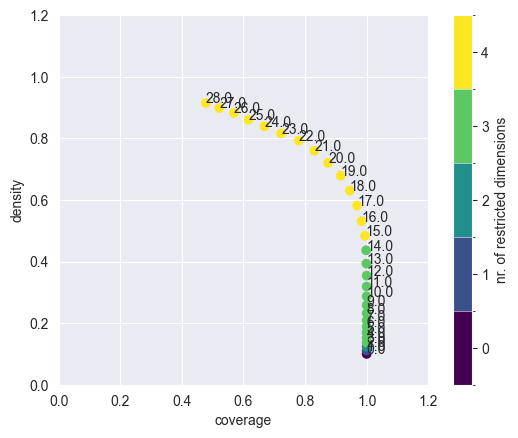

In [27]:
# Plot the trade-off curve
box_damages.show_tradeoff(annotated=True)
plt.show()

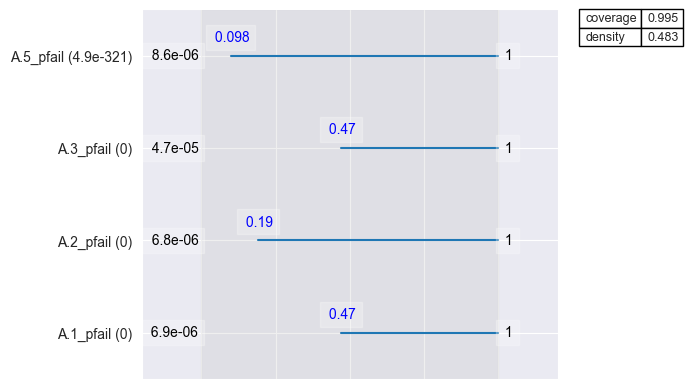

In [43]:
box_damages.inspect(15, style='graph')
plt.show()

In [40]:
ema_logging.log_to_stderr(ema_logging.INFO)
prim_alg = prim.Prim(x=x, y=df_deaths['y_worst'], threshold= 0.8, peel_alpha= 0.1)

box_deaths_worst = prim_alg.find_box()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 800000 points remaining, containing 80000 cases of interest
[MainProcess/INFO] mean: 0.8875305038518589, mass: 0.0522475, coverage: 0.4637125, density: 0.8875305038518589 restricted_dimensions: 2


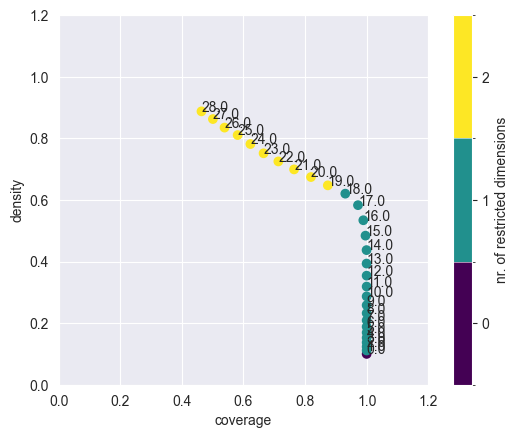

In [41]:
# Plot the trade-off curve
box_deaths_worst.show_tradeoff(annotated=True)
plt.show()

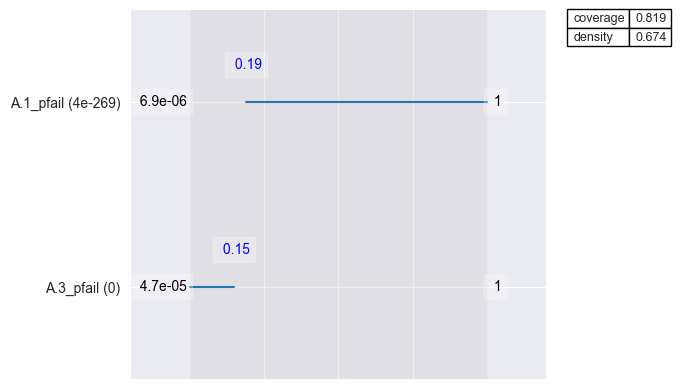

In [47]:
box_deaths_worst.inspect(20, style='graph')
plt.show()

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)
prim_alg = prim.Prim(x=x, y=y_best_costs, threshold= 0.8, peel_alpha= 0.1)

box_costs = prim_alg.find_box()